# Data Analysis

Let's see what kind of data set we are dealing with.


In [1]:
import pydicom
import glob, pylab, pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import random

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


First, we identify the location of the training images, **trainingImagesDir**. 
Then, we add the image_names to a list called **trainingImagesID**

In [2]:
# makes the all training .dcm file names into a list
trainingImagesDir = "/home/ubuntu/stage_1_train_images/"
trainingImagesID = [f for f in listdir(trainingImagesDir) if isfile(join(trainingImagesDir, f))]

Now, let's visualize 10 of the images. 

**pydicom.pixel_array** returns an array with the size (512, 512) for this case. 

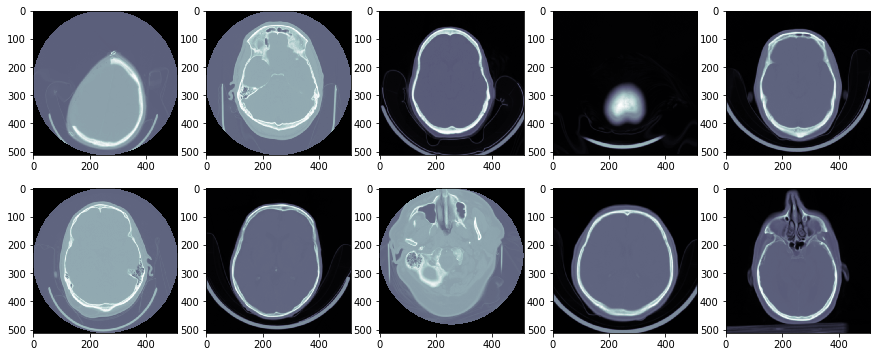

In [3]:
# visualize images
fig= plt.figure(figsize = (15,6))
columns =5 ; rows = 2
for i in range (1, columns*rows+1):
    dataSet = pydicom.dcmread(trainingImagesDir +trainingImagesID[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(dataSet.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot 

Now, let's change the pixel_array to HU units

**Explanation about HU units**
http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.11.2.html

U = m*SV + b

where U is in output units, m is the rescale slope, SV is the stored value, and b is the rescale intercept. 

Function **choose_window** is going to choose the minimum and maximum valu


In [4]:
def get_current_window(dcm_image):

    window_center = dcm_image[('0028', '1050')].value
    window_width = dcm_image[('0028', '1051')].value
    slope_intercept = dcm_image[('0028', '1052')].value
    slope = dcm_image[('0028', '1053')].value

    return [window_center, window_width, slope_intercept, slope]

In [5]:
# testing if get_current_window works
[window_center, window_width, slope_intercept, slope] = get_current_window(dataSet)

print("window_center: ", window_center)
print("window_width: ", window_width)
print("slope_intercept: ", slope_intercept)
print("slope: ", slope)

window_center:  ['00036', '00036']
window_width:  ['00080', '00080']
slope_intercept:  -1024
slope:  1


In [6]:
def pixel2HU(dcm_image):
    """
    
    This function recieves the image in .dcm format and returns a rescaled version of the image 
    
    Using the equation, U = m*SV + b, 
    
    where U is in output units, m is the rescale slope, SV is the stored value, and b is the rescale intercept.     
    
    Arguments: 
    dcm_image: image in .dcm format
    pixel_image: array of original pixel values of the image: size (512, 512) array
    HU_image: array of rescaled values in HU units: size (512, 512) array
    
    """
    pixel_image = dcm_image.pixel_array
    HU_image = pixel_image * dcm_image.RescaleSlope + dcm_image.RescaleIntercept
    HU_image[HU_image < -1024] = -1024
    if HU_image.shape != (512,512):
        padding_h = np.int((512-HU_image.shape[0])/2)
        padding_w = np.int((512-HU_image.shape[1])/2)
        resized_image = np.zeros((512,512),dtype=np.float32)
        resized_image[padding_h:512-padding_h,padding_w:512-padding_w]=HU_image
        HU_image=resized_image
    return HU_image

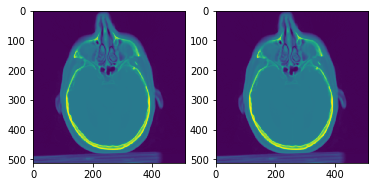

In [7]:
# visualize the change from original pixel_array to HU units
new_image=pixel2HU(dataSet)

fig= plt.figure(figsize = (6,4))
fig.add_subplot(1, 2, 1)
plt.imshow(dataSet.pixel_array)
fig.add_subplot(1, 2, 2)
plt.imshow(new_image)

In [8]:
def set_window(HU_image, window_center=50, window_width=130, ymin=0, ymax=255):
    x = HU_image
    c = window_center
    w = window_width    
    y = np.zeros_like(x)
    y[x <= (c - 0.5 - (w - 1) / 2)] = ymin
    y[x > (c - 0.5 + (w - 1) / 2)] = ymax
    y[(x > (c - 0.5 - (w - 1) / 2)) & (x <= (c - 0.5 + (w - 1) / 2))] = \
        ((x[(x > (c - 0.5 - (w - 1) / 2)) & (x <= (c - 0.5 + (w - 1) / 2))] - (c - 0.5)) / (w - 1) + 0.5) * (
                ymax - ymin) + ymin
    return y        
    #return rescaled_image

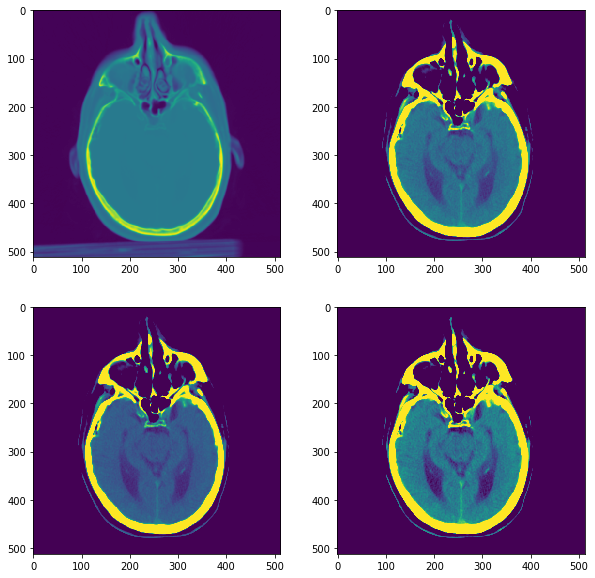

In [9]:
# comparison of different windows
window_center = 50
window_width = 130
new_image_2=set_window(new_image, window_center, window_width)

window_center = 70
window_width = 170
new_image_3=set_window(new_image, window_center, window_width)

window_center = 40#100
window_width = 80#240
new_image_4=set_window(new_image, window_center, window_width)

fig= plt.figure(figsize = (10,10))
fig.add_subplot(2, 2, 4)
plt.imshow(new_image_4)
fig.add_subplot(2, 2, 3)
plt.imshow(new_image_3)
fig.add_subplot(2, 2, 2)
plt.imshow(new_image_2)
fig.add_subplot(2, 2, 1)
plt.imshow(new_image)

Now let's preprocess the data. Get the image_array (512, 512, 1) into vector x_train in order (512, 512, 1, #of examples). 

To minimize the data storage, 

- 1) Open the .csv file and read an ID
- 2) Add the label of the ID to y_train
- 3) Open the ID+ ".dcm" image and process the image to the correct window setting 
- 4) Add the processed image array to x_train 
- 5) Loop and iterate

In [10]:
arr= [0.2, 0.3, 0.4]

index= random.choice(np.arange(len(arr)))
print(index)

0


In [11]:
def generate_training_set_on_the_fly(path ,ID, Label, batch_size):
    print("entered")
    # Create empty array to contain a batch of (X,Y)
    batch_X = np.zeros((batch_size, 512, 512, 1),dtype=np.float32)
    batch_Y = np.zeros((batch_size, 6),dtype=np.float32)
    while True: 
        for i in range(batch_size):
            index = random.choice(np.arange(len(ID)))
            pixel_image_temp= pydicom.dcmread(path+ID[index]+".dcm")
            HU_image_temp=pixel2HU(pixel_image_temp)
            rescaled_image_temp=set_window(HU_image_temp)
            batch_X[i] = rescaled_image_temp.reshape(512,512,1)/255. # normalization
            batch_Y[i] = Label[index]
        yield batch_X, batch_Y    
    print("exited")

In [12]:
"""
# Previous code for preprocessing data 
# Please ignore
m = len(trainingImagesID)
batch_size = 256
TrainingData = pd.read_csv("processed_stage_1_train.csv")

# we need to make multiple lists because numpy doesn't seem to allow big trianingsets. 
x_train = np.zeros((batch_size, 512, 512, 1), dtype=np.float32)
y_train = np.zeros((6, batch_size), dtype=np.float32)
 
y_train = TrainingData.to_numpy()[0:batch_size,1:7].T

i=0
for ID in TrainingData.ID[:batch_size]:
    pixel_image_temp= pydicom.dcmread(trainingImagesDir+ID+".dcm")
    HU_image_temp=pixel2HU(pixel_image_temp)
    rescaled_image_temp=set_window(HU_image_temp)
    x_train[i,:,:,:]=rescaled_image_temp.reshape(512, 512, 1)
    i=i+1
    
"""

'\nm = len(trainingImagesID)\nbatch_size = 256\nTrainingData = pd.read_csv("processed_stage_1_train.csv")\n\n# we need to make multiple lists because numpy doesn\'t seem to allow big trianingsets. \nx_train = np.zeros((batch_size, 512, 512, 1), dtype=np.float32)\ny_train = np.zeros((6, batch_size), dtype=np.float32)\n \ny_train = TrainingData.to_numpy()[0:batch_size,1:7].T\n\ni=0\nfor ID in TrainingData.ID[:batch_size]:\n    pixel_image_temp= pydicom.dcmread(trainingImagesDir+ID+".dcm")\n    HU_image_temp=pixel2HU(pixel_image_temp)\n    rescaled_image_temp=set_window(HU_image_temp)\n    x_train[i,:,:,:]=rescaled_image_temp.reshape(512, 512, 1)\n    i=i+1\n    \n'

In [14]:
# please ignore
# previous method from getting data
def get_training_data():
    return x_train, y_train

In [15]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base +'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [16]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [17]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (512, 512, 1), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X ,f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X ,f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X ,f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform())(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [18]:
model = ResNet50(input_shape = (512, 512, 1), classes = 6)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
"""
x_train_orig, y_train_orig = get_training_data()

#Normalize image vectors
x_train = x_train_orig/255.

# Convert training labels to one hot matrices
y_train = y_train_orig.T

print ("number of training examples = " + str(x_train.shape[0]))
#print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))

"""

'\nx_train_orig, y_train_orig = get_training_data()\n\n#Normalize image vectors\nx_train = x_train_orig/255.\n\n# Convert training labels to one hot matrices\ny_train = y_train_orig.T\n\nprint ("number of training examples = " + str(x_train.shape[0]))\n#print ("number of test examples = " + str(X_test.shape[0]))\nprint ("X_train shape: " + str(x_train.shape))\nprint ("Y_train shape: " + str(y_train.shape))\n\n'

In [21]:
TrainingData = pd.read_csv("processed_stage_1_train.csv")
Label = TrainingData.to_numpy()[0:2047,1:7]
ID = TrainingData.to_numpy()[0:2047,0] #.reshape(len(ID),1) #len(ID)
print("Label", Label.shape)
print("ID", ID.shape)

Label (2047, 6)
ID (2047,)


In [22]:
print(len(ID))

2047


In [23]:
batch_size = 128
history=model.fit_generator(generate_training_set_on_the_fly(trainingImagesDir,ID,Label, batch_size), steps_per_epoch=8, epochs=13)


Epoch 1/13
entered
8/8 [==============================] - 2349s 294s/step - loss: 3.0087 - accuracy: 0.8796
Epoch 2/13
8/8 [==============================] - 2351s 294s/step - loss: 1.3084 - accuracy: 0.9412
Epoch 3/13
8/8 [==============================] - 2347s 293s/step - loss: 0.9438 - accuracy: 0.9271
Epoch 4/13
8/8 [==============================] - 2352s 294s/step - loss: 0.3107 - accuracy: 0.9355
Epoch 5/13
8/8 [==============================] - 2345s 293s/step - loss: 0.3776 - accuracy: 0.9450
Epoch 6/13
8/8 [==============================] - 2340s 292s/step - loss: 0.6283 - accuracy: 0.9308
Epoch 7/13
8/8 [==============================] - 2350s 294s/step - loss: 0.4840 - accuracy: 0.9326
Epoch 8/13
8/8 [==============================] - 2357s 295s/step - loss: 1.0222 - accuracy: 0.9391
Epoch 9/13
8/8 [==============================] - 2359s 295s/step - loss: 0.7456 - accuracy: 0.9325
Epoch 10/13
8/8 [==============================] - 2372s 296s/step - loss: 0.3345 - accuracy

AttributeError: 'function' object has no attribute 'plot'

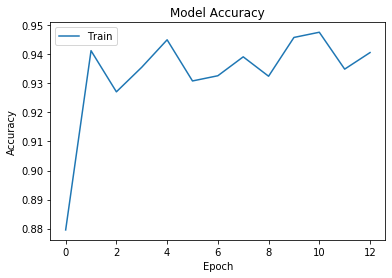

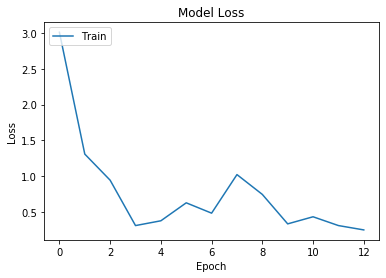

In [26]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'],loc ='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'],loc ='upper left')
plt.show()